## Week 13: Sentiment Analysis using Bert embeddings and Logistic for the downstream task



#### ``Objectives``
1. Load a pre-trained BERT embeddings model. Let's call this **bert_model**.
2. Use the BERT sentence embeddings to clasify the sentiment of drug reviews (this is a downstream task). Let's call this **logit_model**.
3. Fine-tune the classification model.

#### ``Motivation``

1. Drug reviews can provide medical care information for both healthcare professionals and patients. They help understand the side effects and effectiveness level of drugs before prescribing or taking them.

2. Try a different embedding strategy: remember that we need to convert sequences of word tokens to a vector representation that we can then use in a prediction model (downstream task). We will do this using a pre-trained BERT model (this is what transfer learning means).

3. Fine-tune your prediction model by unfreezing layers of your BERT model.

4. BERT provides a nice balance between popularity and having a manageable model size. It can be fine-tuned on a single GPU!

#### ``Motivating papers``


Transformer models have revolutionized NLP and have been at the forefront of many impressive applications. Transformers rely on *self-attention* mechanisms. The architecture was first proporsed in the NeurIPS 2017 paper [Attention is All you Need](https://proceedings.neurips.cc/paper/2017/file/3f5ee243547dee91fbd053c1c4a845aa-Paper.pdf).

A popular language model that uses the transformer architecture is [BERT](https://arxiv.org/abs/1810.04805). To familiarize yourself with BERT, briefly describe the 2 pretraining tasks discussed in the introduction to the paper.

#### ``Pre-trained BERT model (PubMedBert)``

[HuggingFace](https://huggingface.co/docs/transformers/index) provides a standard interface for tokenizers and transformers in Tensorflow and PyTorch. They also provide a platform for reserachers to share pretrained models. For example, we will load a pretrained BERT model from HuggingFace: the [PubMedBERT model + tokenizer](https://huggingface.co/cambridgeltl/SapBERT-from-PubMedBERT-fulltext) that has been trained on a dataset of biomedical texts.

<span style="color:chocolate">Question:</span> Is there a benefit to using a BERT model that has been pretrained on biomedical text compared with, for example, a BERT model trained on Wikipedia?

#### ``BERT architecture``

I mentioned above that BERT relies on the transformer architecture. What does it mean? Well, instead of processing sequence data one-at-a-time (this is what RNN/LSTM does), transformers process entire sequences at once. The good thing is that they still model dependencies between sequence elements.

<span style="color:chocolate">Question:</span> What is the mechanism that transformers use to model sequence dependencies? (you can refer to the [Attention is all you need](https://proceedings.neurips.cc/paper/2017/file/3f5ee243547dee91fbd053c1c4a845aa-Paper.pdf) paper)

#### ``Data``

Our data ([download link](https://drive.google.com/file/d/1ZWzmnIykk63pJuEBTonxbC4CBXJjI6t5/view?usp=sharing)) provides patient reviews on specific drugs and related conditions, and a 10-star rating reflecting overall patient satisfaction. The data was obtained by crawling online pharmaceutical review sites.

We will **build** and **train** a NN model to predict if a review is positive (1) or negative (0).


<u>Note</u>: the original dataset is hosted by UCI - Machine Learning Repository [[Source]](https://archive.ics.uci.edu/ml/datasets/Drug+Review+Dataset+%28Drugs.com%29).

Import the necessary libraries and make sure to replace DATA_PATH with the path to the directories where you saved the data.

In [ ]:
pip install transformers

In [ ]:
# standard
import pandas as pd
import numpy as np
import random
import os

# sklearn
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import cross_val_score

# tf and keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import MaxPooling1D
from tensorflow.keras.layers import GlobalAveragePooling1D
from tensorflow.keras.layers import Embedding
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import sequence
from sklearn.preprocessing import LabelEncoder
import tensorflow_datasets as tfds

# BERT
import transformers
from transformers import AutoTokenizer, TFAutoModel


# plots and images
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import Image

# others
import re
import tqdm
import warnings
warnings.filterwarnings("ignore")

#silence TF
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'


random.seed(2)
%matplotlib inline

# FILL IN CODE HERE #
DATA_PATH = '/content/drive/MyDrive/drugs_raw.csv' # replace with your path

``Functions``

In [ ]:
def preprocessor(text):
    text = re.sub('<[^>]*>', '', text)
    emoticons = re.findall('(?::|;|=)(?:-)?(?:\)|\(|D|P)',
                           text)
    text = (re.sub('[\W]+', ' ', text.lower()) +
            ' '.join(emoticons).replace('-', ''))
    return text

In [ ]:
def tokenize(reviews, labels, tokenizer, seq_length):
    ''''''
    # tokenize reviews (this will give you: input_ids, token_type_ids, attention_mask)
    reviews_tokenized = [
        tokenizer(
            n,
            return_tensors='tf',
            truncation=True,
            padding='max_length',
            max_length=seq_length) for n in reviews
    ]

    reviews_tokenized_tensor = tf.convert_to_tensor([
                            (reviews_tokenized[i]['input_ids'],
                              reviews_tokenized[i]['token_type_ids'],
                              reviews_tokenized[i]['attention_mask'])
                         for i in range(len(reviews_tokenized))
    ])

    # remove empty dimension
    reviews_tokenized_tensor = reviews_tokenized_tensor[:,:,0,:]

    # tensor labels
    labels_tensor = np.array(labels)

    return reviews_tokenized_tensor, labels_tensor

In [ ]:
def get_bert_embeddings(bert_auto_model, reviews_tokenized_tensor, feature_size=768):
    ''''''
    n = len(reviews_tokenized_tensor)
    seq_len = reviews_tokenized_tensor[0][0].shape[0]
    #bert_pool_embeddings = np.zeros((n, seq_len, feature_size)) # for token embeddings
    bert_pool_embeddings = np.zeros((n, feature_size)) # for sentence embeddings
    bs = 128
    nsteps = n//bs+1

    for i in tqdm.trange(n//bs+1):
        slc = slice(i*bs, (i+1)*bs)
        data = reviews_tokenized_tensor[slc]
        input_ids, token_type_ids, attention_mask = data[:,0], data[:,1], data[:,2]
        #embedding = bert_auto_model(input_ids, token_type_ids, attention_mask).last_hidden_state # for token embeddings
        embedding = bert_auto_model(input_ids, token_type_ids, attention_mask).pooler_output # for sentence embeddings
        bert_pool_embeddings[slc] = embedding

    return bert_pool_embeddings

In [ ]:
def confusion_matrix_plot(conf_matrix):
    """ Confusion matrix matplotlib plot
    # param conf_matrix: nested list of TP, TN, FP, FN
    # return: None
    """
    fig, ax = plt.subplots(figsize=(2.5, 2.5))
    ax.matshow(conf_matrix, cmap=plt.cm.Blues, alpha=0.3)
    for i in range(conf_matrix.shape[0]):
        for j in range(conf_matrix.shape[1]):
            ax.text(x=j, y=i, s=conf_matrix[i, j], va='center', ha='center')

    plt.xlabel('Predicted label')
    plt.ylabel('True label')

    plt.tight_layout()
    plt.show()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


---
## Read data

In [ ]:
df_init = pd.read_csv(DATA_PATH)
print('Number of reviews:', df_init.shape[0])
print('Reviews collected between:', df_init.date.min(), 'and ', df_init.date.max())
print('Unique rating values:', np.sort(df_init.rating.unique()))
df_init.head()

Number of reviews: 215063
Reviews collected between: April 1, 2008 and  September 9, 2017
Unique rating values: [ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10.]


,Unnamed: 0,drugName,condition,review,rating,date,usefulCount
0,0,Valsartan,Left Ventricular Dysfunction,"""It has no side effect, I take it in combinati...",9.0,"May 20, 2012",27
1,1,Guanfacine,ADHD,"""My son is halfway through his fourth week of ...",8.0,"April 27, 2010",192
2,2,Lybrel,Birth Control,"""I used to take another oral contraceptive, wh...",5.0,"December 14, 2009",17
3,3,Ortho Evra,Birth Control,"""This is my first time using any form of birth...",8.0,"November 3, 2015",10
4,4,Buprenorphine / naloxone,Opiate Dependence,"""Suboxone has completely turned my life around...",9.0,"November 27, 2016",37


---
## Data preprocessing

When building a neural network, it is import to get the data into the proper form. Let's do a couple of text preprocessing steps.

``Step 1: Remove unwanted review characters``

In [ ]:
# remove HTML markup, punctuation, and other non-letter characters
df_init['review'] = df_init['review'].apply(preprocessor)

``Step 2: Remove outlier reviews``

I want to remove any reviews with no text or extremely long text. Let's see if we find any such reviews.

In [ ]:
# find zero-length reviews
zero_len_reviews = df_init[df_init['review'].str.len().eq(1)]
print("Zero-length reviews: {}".format(zero_len_reviews.shape[0]))
display(zero_len_reviews)

Zero-length reviews: 2


,Unnamed: 0,drugName,condition,review,rating,date,usefulCount
123174,123174,Ifosfamide,Testicular Cance,,10.0,"January 8, 2017",0
128652,128652,Ifex,Testicular Cance,,10.0,"January 8, 2017",0


In [ ]:
# find extremely long text reviews
print('Distribution of review length:')
display(df_init.review.str.len().describe())

# print number of reviews with more than 800 tokens
print('\nReviews with more than 800 tokens:', df_init[df_init.review.str.len().gt(800)].shape[0])

Distribution of review length:


count    215063.000000
mean        444.877552
std         233.744124
min           1.000000
25%         254.000000
50%         443.000000
75%         670.000000
max       10416.000000
Name: review, dtype: float64


Reviews with more than 800 tokens: 690


It seems that I have two reviews with zero length and 374 reviews with more than 1000 tokens. I am going to remove them from our data.

In [ ]:
# remove zero length and extremely long reviews
df_init = df_init[df_init['review'].str.len().gt(1) & df_init['review'].str.len().le(800)]
print('Number of reviews:', df_init.shape[0])

Number of reviews: 214371


Finally, let's look at the distribution of our reviews length after preprocessing

Text(0.5, 0, 'Number of tokens per review')

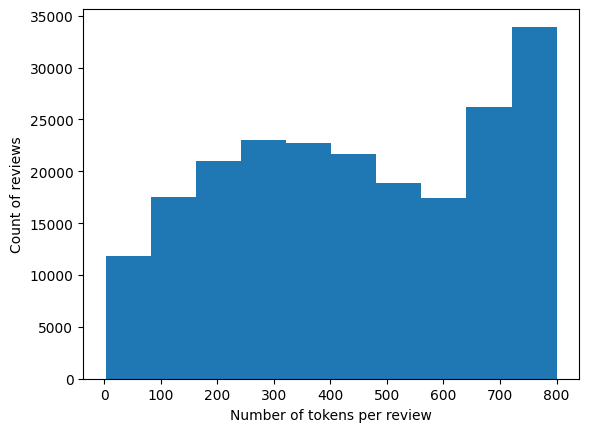

In [ ]:
plt.hist(df_init.review.str.len());
plt.ylabel('Count of reviews')
plt.xlabel('Number of tokens per review')

``Step 2: Create binary sentiment column``

We will define our sentiment column as follows:

   - positive (1) if rating score is between 8-10
   - negative (0) if rating score is between 1-3
    
We dill drop any reviews that are netural, i.e., rating is between 4-7.

In [ ]:
# create sentiment column
df_init['sentiment'] = np.where(df_init.rating.isin((1, 2, 3)), 'negative',
                          np.where(df_init.rating.isin((8,9,10)), 'positive', 'neutral'))

# drop review if sentiment is netural
df = df_init[~df_init.sentiment.eq('neutral')]

# rename sentiment to positive = 1, negative = 0
df['sentiment'] = np.where(df.sentiment.eq('positive'), 1, 0)

Let's do a quick inspection of our rating and sentiment columns

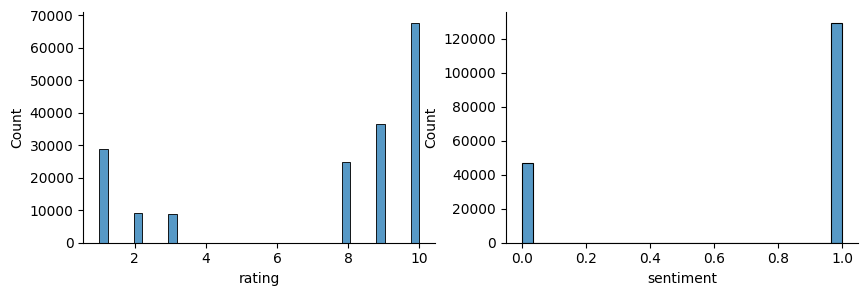

In [ ]:
# rating and sentiment histogram after preprocessing
cols = ['rating', 'sentiment']
nrows, ncols = 1, 2

f, axs = plt.subplots(1, 2, figsize=(10,3))
for idx, ax in enumerate(axs):
    sns.histplot(
    data=df,
    stat="count",
    x = cols[idx],
    ax=ax
    )

    # add labels and ticks
    ax.set(xlabel=cols[idx])
    #plt.xticks(np.arange(1,11,1))
    sns.despine()

Our dataset is very imbalanced. We will correct for class imbalance by taking only 46,000 random examples from each class.

In [ ]:
# randomly draw 46000 examples from each class
temp_positive = df[df.sentiment.eq(1)].sample(
    n=46000,
    replace=False
)

temp_negative = df[df.sentiment.eq(0)].sample(
    n=46000,
    replace=False
)

df_balanced = pd.concat(
    [temp_positive, temp_negative],
    axis=0)

# shuffle df_balanced
df_balanced.sample(frac=1) # frac=1 retains all the data
df_balanced.reset_index(drop=True, inplace=True) # reset index

print('After preprocessing, our data contains', df_balanced.shape[0], 'reviews.')

After preprocessing, our data contains 92000 reviews.


``Step 3: Split data into training, val, test``

We will do a [60, 20, 20] split between training, validation and test sets

In [ ]:
# first, keep only review and sentiment from df_balanced
df_balanced = df_balanced[['review', 'sentiment']]
df_balanced.head(5)

,review,sentiment
0,this medicine has got me off herion after a 1...,1
1,when i started mononessa a year ago the first...,1
2,the ring became pale in 2 days and was gone i...,1
3,i became addicted to opiates when i started h...,1
4,lol don 039 t be such babies men are supposed...,1


In [ ]:
# split = [60, 20, 20]
train_valid_reviews, test_reviews, train_valid_labels, test_labels =train_test_split(
    df_balanced.review,
    df_balanced.sentiment,
    test_size=0.20,
    random_state=1,
    shuffle=True
)

train_reviews, valid_reviews, train_labels, valid_labels = train_test_split(
    train_valid_reviews,
    train_valid_labels,
    test_size=0.20,
    random_state=1,
    shuffle=True
)

In [ ]:
print('Size train reviews:', len(train_reviews))
print('Size dev reviews', len(valid_reviews))
print('Size test reviews', len(test_reviews))

Size train reviews: 58880
Size dev reviews 14720
Size test reviews 18400


``Step 4: Pre-trained embeddings``

We will start by loading the pre-trained PubMedBert tokenizer and model.

In [ ]:
#from transformers import AutoTokenizer, TFAutoModel
hf_model = "cambridgeltl/SapBERT-from-PubMedBERT-fulltext"
if 'tokenizer' not in locals().keys(): tokenizer = AutoTokenizer.from_pretrained(hf_model)
if 'bert_auto_model' not in locals().keys(): bert_model = TFAutoModel.from_pretrained(hf_model)
tokenizer = AutoTokenizer.from_pretrained(hf_model)
bert_model = TFAutoModel.from_pretrained(hf_model)
bert_model.summary()

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['embeddings.position_ids']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.
Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['embeddings.position_ids']
- This IS expected if you are initializing TFBertModel from a PyTorch model trai

Model: "tf_bert_model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert (TFBertMainLayer)      multiple                  109482240 
                                                                 
Total params: 109,482,240
Trainable params: 109,482,240
Non-trainable params: 0
_________________________________________________________________


The **AutoTokenizer** class turns the list of words that make up a given review into a list of tokenized integers that represent those words. The tokenizer then pads all examples to the same size (`input_ids`). The tokenizer also creates another variable to tell BERT to ignore (`attention_mask`) the padding it added when it processed each sentence.


The **TFAutoModel** class creates the embeddings that we will use in a downstram task, i.e., to predict the setiment of drug reviews.

Our pre-trained BERT Model has 109,482,240 parameters! This is a lot, but luckily, we don't need to train the model because it was already pre-trained for us. We will just do transfer learning.

Let's look at one example to see how our BERT tokenizer works:

In [ ]:
example = 'I feel sick after taking this medication'
tokenizer(example)

{'input_ids': [2, 51, 9248, 11258, 2256, 6303, 2052, 6093, 3], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1]}

We can now apply the tokenizer to our trainining, validation and test datasets.

<span style="color:chocolate">Tokenize, pad and mask training, valid, test data </span>

The function **tokenize()** defined at the top of the notebook will do his for us

In [ ]:
train_reviews_tokenized_tensor, train_labels_tensor = tokenize(
    train_reviews, train_labels, tokenizer, seq_length=125
)

valid_reviews_tokenized_tensor, valid_labels_tensor = tokenize(
    valid_reviews, valid_labels, tokenizer, seq_length=125
)

test_reviews_tokenized_tensor, test_labels_tensor = tokenize(
    test_reviews, test_labels, tokenizer, seq_length=125
)

I will print an example to see how the output looks looks like

In [ ]:
print('Tokenized train reviews shape:', train_reviews_tokenized_tensor.shape)  # explain what the 3 channels mean

print('Train labels shape:', train_labels_tensor.shape)

Tokenized train reviews shape: (58880, 3, 125)
Train labels shape: (58880,)


The first dimension of train_reviews_tokenized_tensor represents the number of examples we have in the training data. The second dimension represents the *input_ids*, *token_type_ids*, and *attention_mask* keys of the tokenizer class. The third dimension represents the length of each review in our data (remember, we truncated it down to 125 tokens).

In [ ]:
# print input_ids for the first example in our trainining data
train_reviews_tokenized_tensor[0][0]

<tf.Tensor: shape=(125,), dtype=int32, numpy=
array([    2,    51,  8659, 12258,  1924,  1958,  2559,  2739,  1956,
        2447,  4159,  2564,  2406,  3057,  8017,  5463,  2237,  5410,
        4637, 12075,  2485,    43, 10838,  2469,  4703,     3,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,   

In [ ]:
# print attention_mask for the first example in our trainining data
train_reviews_tokenized_tensor[0][2]

<tf.Tensor: shape=(125,), dtype=int32, numpy=
array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int32)>

<span style="color:chocolate">Create BERT sentence embeddings </span>

We will use the bert_model imported above to generate text embeddings applied to our own data. This will take about 11 hours to run on a less powerful but you can also subset to work with less data. Notice that BERT can give you:

 - token embeddings
 - sentence embeddings (this is similar to applying GlobalAveragePooling1D() over token embeddings!)

I set up the get_bert_embeddings() function to output ``sentence embeddings`` directly. What does it mean? Each drug review will have a 1D embedding, and we will use this embeddings to predict if the review is positive (1) or negative (0).

In [ ]:
print("Doing BERT train embeddings")
train_bert_embeddings = get_bert_embeddings(
    bert_model, train_reviews_tokenized_tensor[:1000,:,:]
) #do train_reviews_tokenized_tensor[:2000,:,:] for only 2000 examples

print("Doing BERT val embeddings")
valid_bert_embeddings = get_bert_embeddings(
    bert_model, valid_reviews_tokenized_tensor [:100,:,:]
) #do valid_reviews_tokenized_tensor[:200,:,:] for only 200 examples

print("Doing BERT test embeddings")
test_bert_embeddings = get_bert_embeddings(
    bert_model, test_reviews_tokenized_tensor [:100,:,:]
) #do test_reviews_tokenized_tensor[:200,:,:] for only 200 examples

Doing BERT train embeddings


100%|██████████| 16/16 [18:49<00:00, 70.60s/it]


Doing BERT val embeddings


100%|██████████| 2/2 [01:49<00:00, 54.56s/it]


Doing BERT test embeddings


100%|██████████| 2/2 [01:46<00:00, 53.15s/it]


In [ ]:
train_bert_embeddings.shape  # an embedding vector of size 768 for each review in our data (Note: we chose the embedding size in get_bert_embeddings() function)

(2000, 768)

These embeddings are going to be our BERT features that we can next use in a downstream task.

---
## Fine-tune a sentiment classification model

We will fine-tune our BERT model on a downstream task of sentiment classification.
To do this, we will create a classifier by adding a `Dense` layer on top of the pretrained BERT features.

<span style="color:chocolate">Make BERT layers untrainable (freeze)</span>

In [ ]:
# freeze BERT layers
for layer in bert_model.layers:
    layer.trainable = False

In [ ]:
# create copy of our objects (a bit inefficient (memory size) but let's abstract away from this)
train_x = train_bert_embeddings
train_y = train_labels_tensor[:2000] #do train_labels_tensor[:2000,:,:] for only 2000 examples if you subset the data above

valid_x = valid_bert_embeddings
valid_y = valid_labels_tensor[:200]#do valid_labels_tensor[:200,:,:] for only 200 examples if you subset the data above

test_x = test_bert_embeddings
test_y = test_labels_tensor[:200] #do test_labels_tensor[:200,:,:] for only 200 examples if you subset the data above

Define a model for our Downstream task

In [ ]:
def build_model(num_features):
    """Return a simple logistic regression model using the Keras Sequential API."""
    # clear session and set a random seed for consistent behavior.
    tf.keras.backend.clear_session()
    tf.random.set_seed(1234)


    # sse Keras Sequential API to build a logistic regression
    model = keras.Sequential()

    # create input layer (this will be the sentence embeddings)
    model.add(tf.keras.Input(shape=(num_features, ),
         name='Input'
    ))



    # add output layer for binary classification task
    model.add(Dense(1, use_bias=False, activation='sigmoid'))

    # print model summary
    model.summary()

    return model


# Build the model
logit_model = build_model(num_features=train_x.shape[1])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 1)                 768       
                                                                 
Total params: 768
Trainable params: 768
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# compile logit model
logit_model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(),
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.01),
    metrics=[tf.keras.metrics.BinaryAccuracy()]
)

In [ ]:
# train logit model
tf.random.set_seed(1234)
np.random.seed(1234)
hist= logit_model.fit(x=train_x,
                y=train_y,
                #validation_data=[X_test_std, y_test],
                validation_data=(valid_x, valid_y),
                batch_size=240,
                epochs=100,
                verbose=0 #silence fit
)

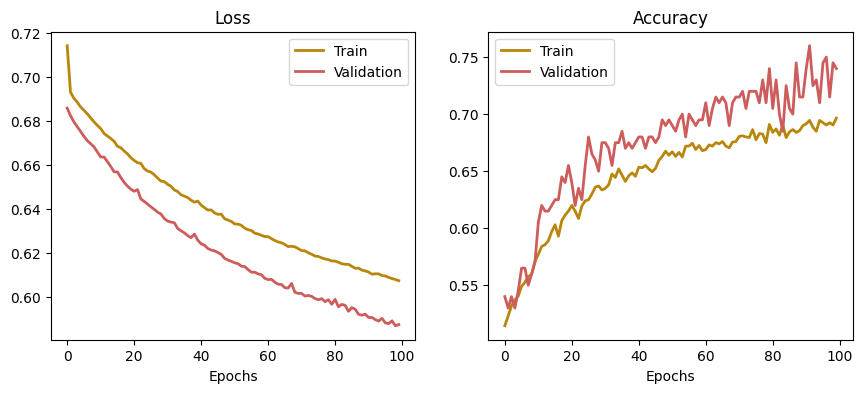

In [ ]:
# grab history
history = hist.history

# plot loss for train and validation
fig = plt.figure(figsize=(16, 4))
ax = fig.add_subplot(1, 3, 1)
plt.plot(history['loss'], lw=2, color='darkgoldenrod')
plt.plot(history['val_loss'], lw=2, color='indianred')
plt.legend(['Train', 'Validation'], fontsize=10)
#plt.ylim(0.5,0.7)
ax.set_xlabel('Epochs', size=10)
ax.set_title('Loss');

# plot accuracy for train and validation
ax = fig.add_subplot(1, 3, 2)
plt.plot(history['binary_accuracy'], lw=2, color='darkgoldenrod')
plt.plot(history['val_binary_accuracy'], lw=2, color='indianred')
plt.legend(['Train', 'Validation'], fontsize=10)
#plt.ylim(0.7,0.8)
ax.set_xlabel('Epochs', size=10)
ax.set_title('Accuracy');

In [ ]:
print('After training this model, evaluation on the validation data shows an accuracy of:',
      np.round(history['val_binary_accuracy'][-1]*100,2), '%'
)

After training this model, evaluation on the validation data shows an accuracy of: 74.0 %


<span style="color:chocolate">Make BERT layers available for training (unfreeze)</span>

In [ ]:
# unfreeze BERT layers
for layer in bert_model.layers:
    layer.trainable = True

In [ ]:
# recompile logit model
logit_model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(),
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.015),
    metrics=[tf.keras.metrics.BinaryAccuracy()]
)

In [ ]:
# retrain logit model
tf.random.set_seed(1234)
np.random.seed(1234)
hist= logit_model.fit(x=train_x,
                y=train_y,
                validation_data=(valid_x, valid_y),
                batch_size=240,
                epochs=300,
                verbose=0 #silence fit
)

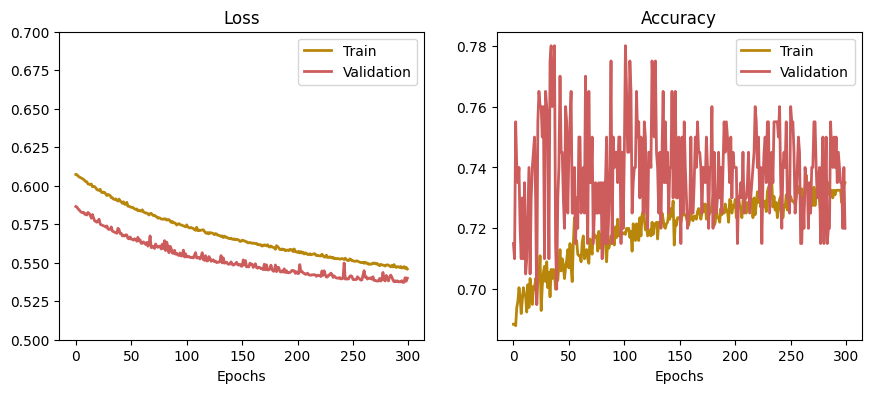

In [ ]:
# grab history
history = hist.history

# plot loss for train and validation
fig = plt.figure(figsize=(16, 4))
ax = fig.add_subplot(1, 3, 1)
plt.plot(history['loss'], lw=2, color='darkgoldenrod')
plt.plot(history['val_loss'], lw=2, color='indianred')
plt.legend(['Train', 'Validation'], fontsize=10)
plt.ylim(0.5,0.7)
ax.set_xlabel('Epochs', size=10)
ax.set_title('Loss');

# plot accuracy for train and validation
ax = fig.add_subplot(1, 3, 2)
plt.plot(history['binary_accuracy'], lw=2, color='darkgoldenrod')
plt.plot(history['val_binary_accuracy'], lw=2, color='indianred')
plt.legend(['Train', 'Validation'], fontsize=10)
#plt.ylim(0.7,0.8)
ax.set_xlabel('Epochs', size=10)
ax.set_title('Accuracy');

In [ ]:
print('After fine-tuning this model, evaluation on the validation data shows an accuracy of:',
      np.round(history['val_binary_accuracy'][-1]*100,2), '%'
)

After fine-tuning this model, evaluation on the validation data shows an accuracy of: 72.0 %


How good is this score? Let's compare it with a dummy classifier.

<span style="color:chocolate">Question: </span> what is a dummy classifier?

In [ ]:
clf = DummyClassifier() # uses Sklearn

scores = cross_val_score(clf, train_x, train_y)
print("Dummy classifier score: %0.3f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Dummy classifier score: 0.513 (+/- 0.00)


---
## Evaluation

<span style="color:chocolate">predictions on test data</span>

In [ ]:
# run the trained model on the test data (the model outputs probabilities)
y_test_pred_p = logit_model.predict(x=test_x).flatten()

# apply the threshold function to create a 0, 1 outcome
y_test_pred = np.where(y_test_pred_p>=0.5, 1, 0)
y_test_pred[:10] # first 10 only

7/7 [==============================] - 0s 2ms/step


array([0, 1, 1, 0, 0, 1, 0, 1, 1, 0])

<span style="color:chocolate">confussion matrix</span>

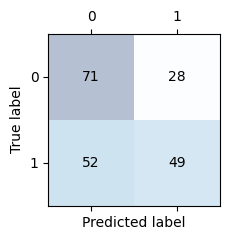

In [ ]:
conf_matrix = tf.math.confusion_matrix(
    test_y,
    y_test_pred,
    num_classes=None,
    weights=None,
    dtype=tf.dtypes.int32,
    name=None
)

confusion_matrix_plot(conf_matrix.numpy())

<span style="color:chocolate">precision score</span>

In [ ]:
# note that TensorFlow assumes that the positive class is cultivar 1
p = tf.keras.metrics.Precision(
    thresholds=None, top_k=None, class_id=None, name=None, dtype=None
)
p.update_state(test_y, y_test_pred)  #18/(18+3)
print("Precision score: %3f" %p.result().numpy())

Precision score: 0.636364


<span style="color:chocolate">recall score</span>

In [ ]:
# note that TensorFlow assumes that the positive class is cultivar 1
r = tf.keras.metrics.Recall(
    thresholds=None, top_k=None, class_id=None, name=None, dtype=None
)
r.update_state(test_y, y_test_pred) #18/(18+1)
print("Recall score: %.3f" %r.result().numpy())

Recall score: 0.485


<span style="color:chocolate">F1 score</span>

In [ ]:
print("F1 score:",
    2*((p.result().numpy()*r.result().numpy())/(p.result().numpy()+r.result().numpy())))

F1 score: 0.550561785697937


<span style="color:chocolate">ROC AUC</span>

ROC AUC: 0.682


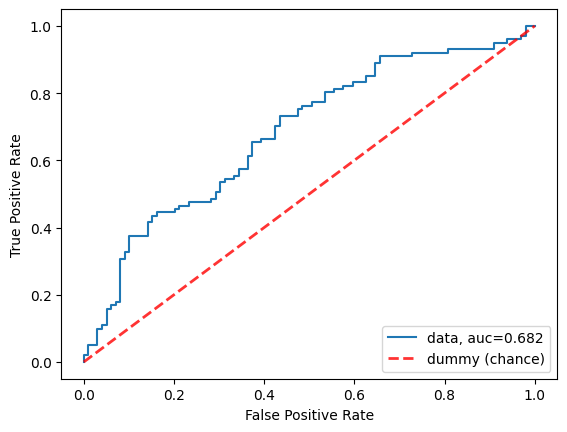

In [ ]:
from sklearn import datasets, metrics, model_selection, svm
fpr, tpr, _ = metrics.roc_curve(test_y,  y_test_pred_p)
auc = metrics.roc_auc_score(test_y, y_test_pred_p)
plt.plot(fpr,tpr,label="data, auc="+str(np.round(auc,3)))
plt.legend(loc=4)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')


# add dummy classifier
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
         label='dummy (chance)', alpha=.8)

plt.legend(loc=4)
print('ROC AUC:', np.round(auc,3))

---
### <span style="color:chocolate">What's next?</span>

A few suggestions for performance improvement:

-  hyperparameter tuning

-  try a different BERT model, e.g., one that has been trained on Wikipedia text. Our PubMedBERT model has been trained on biomedical text - this may be too technical for our drug reviews text.


Below I provide some code snippets to get you started with another BERT model (DistilBert trained on Wikipedia text).

In [ ]:
from transformers import (AutoTokenizer,
                          AutoModelForSequenceClassification,
                          TextClassificationPipeline)

tokenizer_name = "distilbert-base-uncased"
model_name = "distilbert-base-uncased-finetuned-sst-2-english"

tokenizer = transformers.DistilBertTokenizerFast.from_pretrained(tokenizer_name)
model = transformers.DistilBertForSequenceClassification.from_pretrained(model_name).cpu()

pipe = TextClassificationPipeline(model=model, tokenizer=tokenizer, return_all_scores=True)

No CUDA runtime is found, using CUDA_HOME='/usr/local/cuda'
Xformers is not installed correctly. If you want to use memory_efficient_attention to accelerate training use the following command to install Xformers
pip install xformers.
